# Importações

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Pré-processamento
  ### Depois do pré-processamento utilizar o dataframe *ts_rs_residencial* para acessar a série temporal.
  ### timestamps_treino
  ### timestamps_teste
  ### consumo_treino
  ### consumo_teste

In [45]:
#!wget https://www.inf.ufrgs.br/~mpizzutti/CMP618/consumo.csv
df = pd.read_csv('consumo.csv')
df.head()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,RO,Total,NaN,112812.00
1,2004,1,AC,Total,NaN,34840.05
2,2004,1,AM,Total,NaN,274773.00
3,2004,1,RR,Total,NaN,31695.63
4,2004,1,PA,Total,NaN,1011353.04


In [46]:
df['data'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str), format='%Y-%m')
df_rs_residencial = df[(df['sigla_uf'] == 'RS') & (df['tipo_consumo'] == 'Residencial')]
df_rs_residencial.tail()

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo,data
17383,2021,8,RS,Residencial,NaN,756429.24,2021-08-01
17410,2021,9,RS,Residencial,NaN,652923.60,2021-09-01
17437,2021,10,RS,Residencial,NaN,688945.37,2021-10-01
17464,2021,11,RS,Residencial,NaN,743034.01,2021-11-01
17491,2021,12,RS,Residencial,NaN,785861.25,2021-12-01


In [47]:
ts_rs_residencial = df_rs_residencial.drop(['ano','mes','tipo_consumo','numero_consumidores', 'sigla_uf'], axis=1)
ts_rs_residencial = ts_rs_residencial.set_index('data')
ts_rs_residencial.head()

,consumo
data,
2004-01-01,456670.2
2004-02-01,455907.3
2004-03-01,453566.8
2004-04-01,470612.3
2004-05-01,446184.4


In [48]:
# Dividindo os dados em treino e teste
timestamps_treino = ts_rs_residencial[ts_rs_residencial.index<'2018-01-01'].index.values
timestamps_teste = ts_rs_residencial[ts_rs_residencial.index>='2018-01-01'].index.values
consumo_treino = ts_rs_residencial[ts_rs_residencial.index<'2018-01-01'].values
consumo_teste = ts_rs_residencial[ts_rs_residencial.index>='2018-01-01'].values

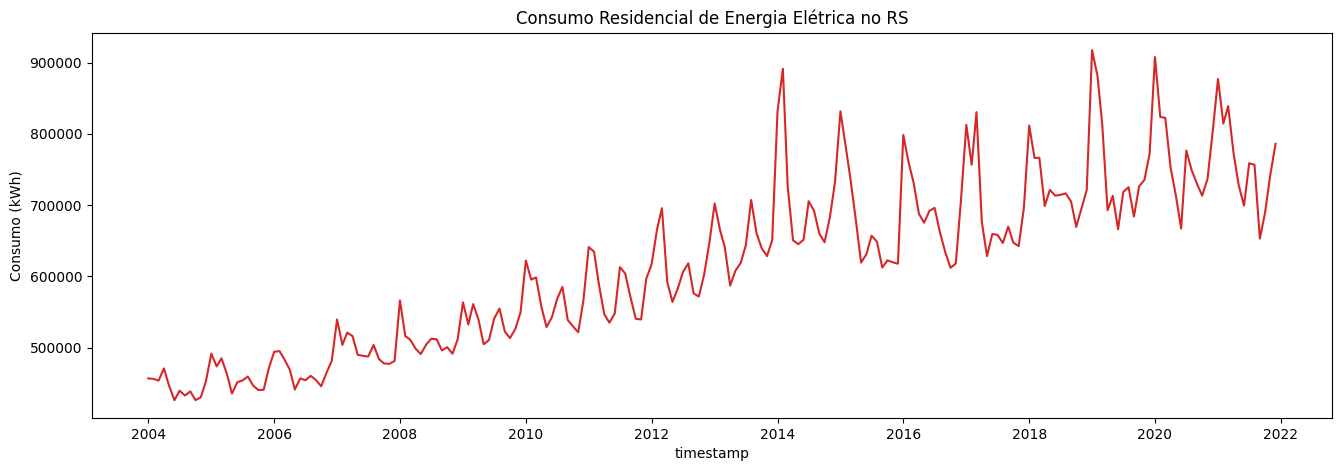

In [49]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_rs_residencial.index, ts_rs_residencial['consumo'], color='tab:red')
plt.gca().set(title='Consumo Residencial de Energia Elétrica no RS', xlabel='timestamp', ylabel='Consumo (kWh)')
plt.show()

# Treinando SVR

/tmp/ipykernel_1982/1487639588.py:35: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  noscaled_consumo_treino = ts_rs_residencial['consumo'][:tamanho_treino].ravel()
/tmp/ipykernel_1982/1487639588.py:36: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  noscaled_consumo_teste = ts_rs_residencial['consumo'][tamanho_treino:].ravel()


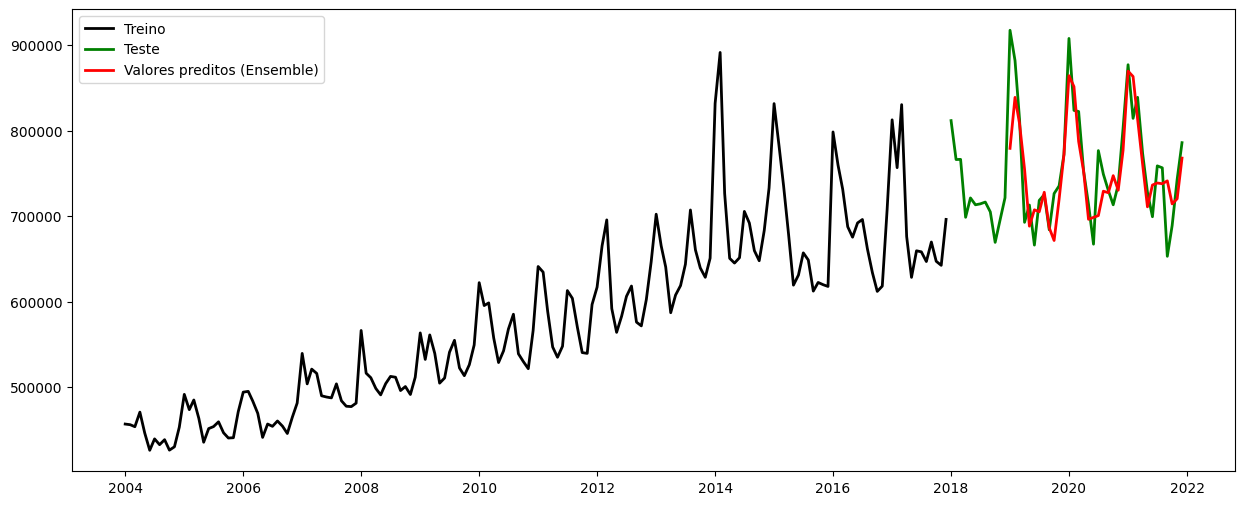

Ensemble RMSE: 40402.30
Ensemble MAE: 29589.66
Ensemble R^2: 0.63


In [50]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pprint import pprint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from scipy.stats import expon, reciprocal
from sklearn.ensemble import VotingRegressor

ts_rs_residencial['consumo'] = ts_rs_residencial['consumo'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(ts_rs_residencial)

scaled_ts_rs_residencial = scaler.transform(ts_rs_residencial)

# Dividindo os dados em treino e teste
tamanho_treino = len(ts_rs_residencial[ts_rs_residencial.index < '2018-01-01'])
timestamps_treino = ts_rs_residencial[ts_rs_residencial.index<'2018-01-01'].index.values
timestamps_teste = ts_rs_residencial[ts_rs_residencial.index>='2018-01-01'].index.values
consumo_treino = scaled_ts_rs_residencial[:tamanho_treino].ravel()
consumo_teste = scaled_ts_rs_residencial[tamanho_treino:].ravel()

def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size ):
        data_x.append(dataset[i:(i + window_size)])
        data_y.append(dataset[i + window_size])
    return np.array(data_x), np.array(data_y)

window_size = 12

yx_train, yy_train = create_dataset(consumo_treino, window_size)
yx_test,  yy_test  = create_dataset(consumo_teste,  window_size)

noscaled_consumo_treino = ts_rs_residencial['consumo'][:tamanho_treino].ravel()
noscaled_consumo_teste = ts_rs_residencial['consumo'][tamanho_treino:].ravel()

# Create individual SVR models
model1 = SVR(C=0.1, epsilon=0.0, gamma=0.5, kernel='linear', coef0=0.0)
model2 = SVR(C=55, epsilon=0.05, gamma=0.4, kernel='rbf', coef0=0.0)
model3 = SVR(C=1, epsilon=0.099, gamma=0.2, kernel='poly', coef0=0.0)

# Create the ensemble model
ensemble_model = VotingRegressor([('linear', model1), ('rbf', model2), ('poly', model3)])

# Fit the ensemble model
ensemble_model.fit(yx_train, yy_train)

# Predict using the ensemble model
y_pred_ensemble = ensemble_model.predict(yx_test)

# Inverse transform the predictions
y_pred_inv_ensemble = scaler.inverse_transform(y_pred_ensemble.reshape(1, -1)).ravel()

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(timestamps_treino, noscaled_consumo_treino, linewidth=2, color='black', label='Treino')
plt.plot(timestamps_teste, noscaled_consumo_teste, linewidth=2, color='green', label='Teste')
plt.plot(timestamps_teste[window_size:], y_pred_inv_ensemble, linewidth=2, color='red', label='Valores preditos (Ensemble)')
plt.legend()
plt.show()

# Calculate evaluation metrics
ensemble_rmse = np.sqrt(mean_squared_error(noscaled_consumo_teste[window_size:], y_pred_inv_ensemble))
ensemble_mae = np.mean(np.abs(noscaled_consumo_teste[window_size:] - y_pred_inv_ensemble))
ensemble_r2 = r2_score(noscaled_consumo_teste[window_size:], y_pred_inv_ensemble)
print(f"Ensemble RMSE: {ensemble_rmse:.2f}")
print(f"Ensemble MAE: {ensemble_mae:.2f}")
print(f"Ensemble R^2: {ensemble_r2:.2f}")